# Description

Scenario :
* 1 receptor
* Comparing results from different protocols

Requirements :
* Run DockFlow multiple times
* Rename the "docking" folders in a significant way, while keeping "docking\_" in the name. The name of these folders while give the name of the method in tables and plots.  
 Exemple : docking_plp and docking_chemplp
* Fill the User Input section of this notebook
* Click on the "Cell" tab, "Run All"

Output :
* Tables
* Bar charts
* RMSD calculations

# User Input

In [1]:
# Path to data
# The notebook should be ran from the working directory folder.
# You can change the path to the summary folder here.
# Default : path = "."
path = "."

In [2]:
# RMSD cutoffs to consider poses as :
# good : close to the crystallographic structure --> between 0.0 and X (excluded) angstroms 
# medium : between X and Y (excluded) angstroms 
# bad : very different from the crystallographic structure : Y to Z (excluded) angstroms

# poses with a RMSD strictly below this value are good
RMSD_good = 2.0
# poses with a RMSD above or equal to the previous limit, and below the following limit are medium
RMSD_medium = 3.0
# poses with a RMSD above or equal to the previous limit, and below the following limit are bad
RMSD_bad = 5.0
# poses with a RMSD above the previous value are discarded 

In [3]:
# Range of selection of the top X docking poses (sorted by PLANTS score) for the protocol validation

top_list = [1,3,5,10]

In [4]:
# Save folder for tables and graphs
# By default, the save folder will be created inside the work directory
# as "ReportFlow/PLANTS_VS_decoys_enrichment"
# You can change the path and names of the save folder here.
# Default : save_folder = "./PLANTS_docking_rescoring_decoys_actives"
save_folder = "./PLANTS_docking"

# Initialization

In [3]:
# Only show output, hide code.
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
# Import python modules

%matplotlib inline

from matplotlib import rcParams
rcParams['mathtext.default'] = 'tt'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
from sklearn.metrics import auc
import os.path

## Process user input

In [6]:
# Create a list of ligands based on folder name
dockfile_list = ! ls -l {path}/docking/ | awk '/^d/{{print $$9}}'

In [7]:
# Create dictionnary for the RMSD ranges
rmsd_limit = {'good'  : [0.0,RMSD_good],
             'medium' : [RMSD_good,RMSD_medium],
             'bad' : [RMSD_medium,RMSD_bad]}

In [8]:
# Create the save folder
! mkdir -p $save_folder

In [28]:
# Check results available
method_list = []
scores_list = []

# list folders in path
folder_list = next(os.walk('.'))[1]

# Docking
for folder in folder_list:
    f = '{}/{}/ranking_sorted.csv'.format(path, folder)
    if os.path.isfile(f):  
        scores_list.append(folder)
print('Results detected : {}'.format(' - '.join(scores_list)))

Results detected : docking_chemplp - docking_plp


## Create Dataframes

In [132]:
# Docking results
docking = {}
docking_detail = {}

for method in scores_list:
    # PLANTS docking results
    f = '{}/{}/ranking_sorted.csv'.format(path, method)
    docking_detail[method] = pd.read_csv(f, header=0)
    docking_detail[method].rename(columns = {'TOTAL_SCORE' : 'SCORE', 'LIGAND_ENTRY' : 'POSE'}, inplace=True)

    # Assign ligand name by splitting the pose name
    docking_detail[method] = docking_detail[method].assign(LIGAND = docking_detail[method].POSE.apply(lambda x: x.split('_')[0]))
    # Add rank
    docking_detail[method].reset_index(inplace=True)
    docking_detail[method].rename(columns = {'index' : 'RANK'}, inplace=True)

    docking[method] = docking_detail[method][['LIGAND','POSE','RANK','SCORE']]
    docking[method]['METHOD'] = method.split('docking_')[1].upper()

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [139]:
# Create actual ligand list
lig_list = docking[method]['LIGAND'].unique().tolist()

In [140]:
# RMSD

for method in scores_list:

    reference_folder = ! grep "lig_folder=" {path}/{method}/DockFlow.config
    reference_folder = reference_folder[0].split('lig_folder="')[1][:-1]
    reference_list = ! cd {reference_folder}; ls -v *.mol2

    rmsd = pd.DataFrame()

    for reference in reference_list:
        ref_file = '{}/{}'.format(reference_folder,reference)
        output_file = '{}/rmsd_{}.csv'.format(reference_folder,reference)
        # Remove old output
        ! rm -f {output_file}
        # Compute with Hungarian Algorithm
        ! RMSDFlow -r {ref_file} -i {path}/{method}/lig/*.mol2 -a ha -o {output_file} -s
        # Read
        temp = pd.read_csv(output_file, header=0)
        rmsd = pd.concat([rmsd, temp])

    # drop unused columns
    rmsd.drop(['Number of atoms read', 'Number of atoms in molecule', 'Reference'], axis=1, inplace=True)

    # Add rank by RMSD
    rmsd.sort_values('RMSD', inplace=True)
    rmsd.reset_index(inplace=True, drop=True)
    rmsd.reset_index(inplace=True)
    rmsd.rename(columns = {'index' : 'RMSD_RANK', 'Input' : 'POSE'}, inplace=True)
    # Reorganize
    rmsd = rmsd[['POSE','RMSD_RANK','RMSD']]
    
    docking[method] = pd.merge(docking[method], rmsd, how='left', on=['POSE'] )
    docking[method] = docking[method].assign(DESCRIPTION = docking[method].RMSD.apply(lambda x: 
                                                                   'good' if (x >= rmsd_limit['good'][0] and x < rmsd_limit['good'][1]) 
                                                                   else 'medium' if (x >= rmsd_limit['medium'][0] and x < rmsd_limit['medium'][1])
                                                                   else 'bad' if (x >= rmsd_limit['bad'][0] and x < rmsd_limit['bad'][1])
                                                                  else 'discarded'))

In [148]:
# Match all results
all_scores = pd.DataFrame()

for method in scores_list:
    #all_scores = pd.merge(all_scores, docking[method], how='left', on=['POSE','LIGAND'], suffixes=[i.split('docking')[1].upper() for i in scores_list])
    all_scores = pd.concat([all_scores, docking[method]], axis=0)
    
# only poses with values
all_subset = all_scores.dropna()

In [129]:
# Melted dataframes

values_list = ['DOCKING_{}'.format(i.split('docking_')[1].upper()) for i in scores_list]

# for score
df_scores = pd.melt(all_scores, id_vars=['LIGAND','POSE'], 
             value_vars=values_list, var_name='METHOD', value_name='SCORE')
# for rank
df_rank = pd.melt(all_scores, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['{}_RANK'.format(i) for i in ['PLANTS', 'RMSD']], var_name='METHOD', value_name='RANK')
# rename method to remove "_RANK"
df_rank['METHOD'] = df_rank['METHOD'].apply(lambda x: x.split('_RANK')[0])
df = pd.merge(df_scores, df_rank, how='left', on=['LIGAND','POSE','DESCRIPTION','METHOD'])

# subset only keeping poses with values
# for score
df_scores_subset = pd.melt(all_subset, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['PLANTS', 'RMSD'], var_name='METHOD', value_name='SCORE')
# for rank
df_rank_subset = pd.melt(all_subset, id_vars=['LIGAND','POSE','DESCRIPTION'], 
             value_vars=['{}_RANK'.format(i) for i in ['PLANTS', 'RMSD']], var_name='METHOD', value_name='RANK')
# rename method to remove "_RANK"
df_rank_subset['METHOD'] = df_rank_subset['METHOD'].apply(lambda x: x.split('_RANK')[0])
df_subset = pd.merge(df_scores_subset, df_rank_subset, how='left', on=['LIGAND','POSE','DESCRIPTION','METHOD'])

In [150]:
# Subset of poses with an RMSD below the defined limit

rmsd_good_subset = all_subset.loc[all_subset['RMSD'] <= RMSD_good]

In [151]:
# Count occurencies of RMSD within range for each top range selection

data = []

for method_long in scores_list:
    method = method_long.split('docking_')[1].upper()
    for description in rmsd_limit:
        for top in top_list:
            temp = all_subset.loc[all_subset['METHOD'] == method].sort_values('SCORE')
            occ = len(temp.head(top).loc[ temp['DESCRIPTION'] == description])
            top_string = 'Top {}'.format(top)
            data.append([method,description,top_string,occ])

occurency = pd.DataFrame(data, columns=['Method','Description','Selection Range', 'Occurency'])

In [152]:
# Color palettes
# Create color palette and dictionnary based on the ligand list for the plots
color_list = sns.husl_palette(len(lig_list),0,0.8,0.65)

# Color list based on state (RMSD below or above the limit)       
state_list = ['good', 'medium','bad','discarded']
state_color_list = ['green','blue','orange','red']

# Create a hatch list for plots based on the method list
hatch_list = ['','/', '\\', '-', '.', '//']
method_hatch_list = [hatch_list[i] for i in range(2)]
method_color_list = [[c for c in sns.color_palette("deep")][i] for i in range(2)]

# Set the new custom color list
sns.set_palette(sns.color_palette('deep'))

# Results

## Summary

In [155]:
# not working as intended
all_scores.describe()

,RANK,SCORE,RMSD_RANK,RMSD
count,50.000000,50.000000,50.000000,50.000000
mean,12.000000,-105.593690,12.000000,2.123273
std,7.284314,13.622057,7.284314,0.789129
min,0.000000,-150.573000,0.000000,0.584528
25%,6.000000,-108.756500,6.000000,1.525652
50%,12.000000,-101.832000,12.000000,1.918754
75%,18.000000,-97.543550,18.000000,2.881926
max,24.000000,-93.092600,24.000000,3.155237


## Plots

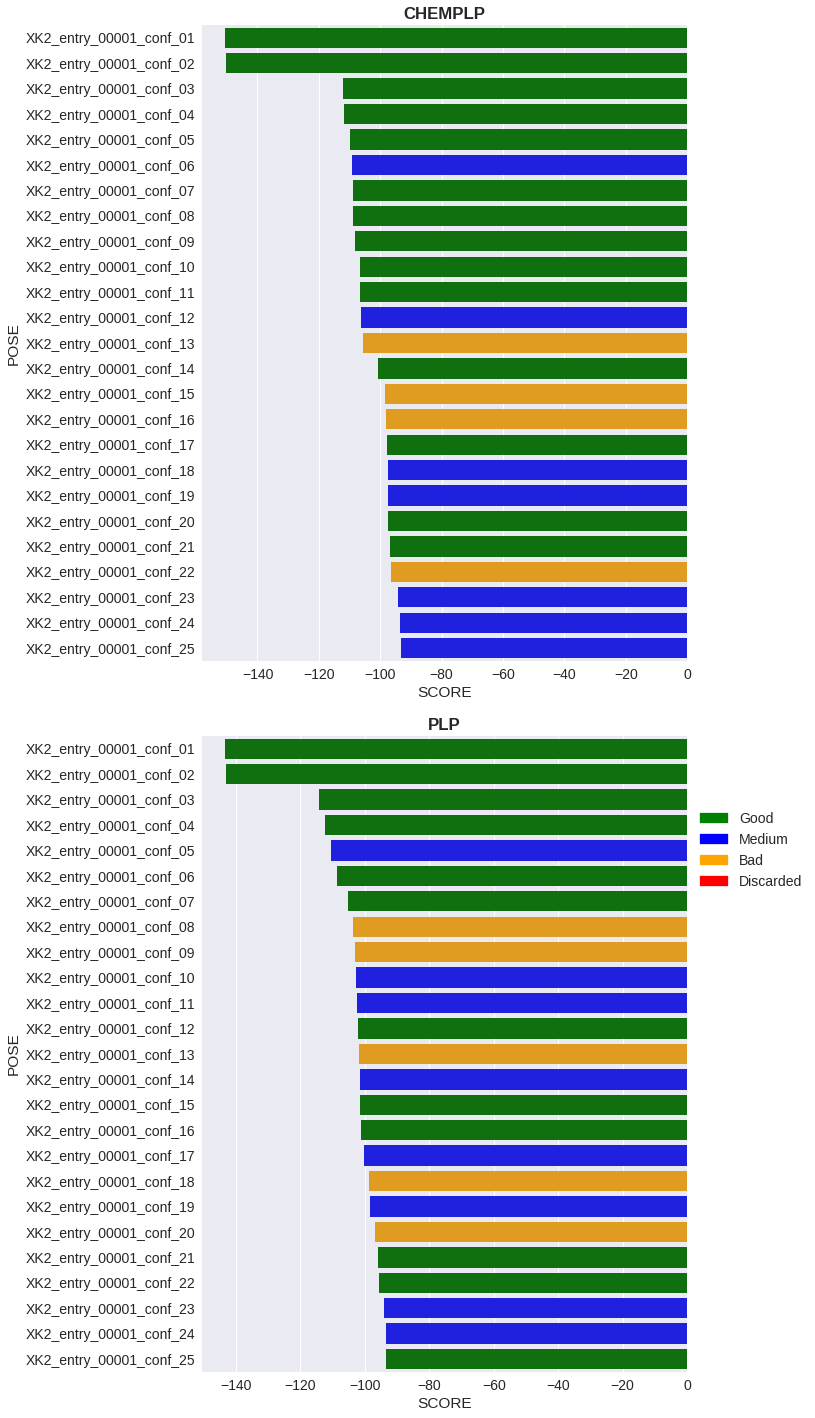

In [160]:
# Sorted barplot colored by RMSD range

def grid_barplot(data,size=15,aspect=3,col_wrap=1):
    aspect = aspect
    size_x = size
    size_y = size_x*aspect
    methods = data.METHOD.unique()
    num_subplots = len(methods)
    num_cols = col_wrap
    num_rows = num_subplots // num_cols
    num_rows += num_subplots % num_cols
    position = range(1, num_subplots+1)

    fig = plt.figure(figsize=(size_x,size_y))
    for method,v in zip(methods, range(num_subplots)):
        data_subset = data.loc[data['METHOD'] == method].sort_values('SCORE')
        order = data_subset.POSE.tolist()
        colors = [state_color_list[0] if (x == 'good') 
                  else state_color_list[1] if (x == 'medium') 
                  else state_color_list[2] if (x == 'bad')
                  else state_color_list[3] for x in data_subset.DESCRIPTION]
        ax = fig.add_subplot(num_rows,num_cols,position[v])
        sns.barplot(x=data_subset['SCORE'], y=data_subset.POSE, 
                    palette=colors,
                    orient='h', order=order, ax=ax, label=method)
        ax.legend().set_visible(False)
        ax.set_title(method,fontweight='bold')
        ax.set_xlabel('SCORE')

    plt.tight_layout()

grid_barplot(data=all_subset, size=10, aspect=2)

#Create custom artists
goodArtist      = plt.Rectangle((0,0),2,1, color=state_color_list[0])
mediumArtist    = plt.Rectangle((0,0),2,1, color=state_color_list[1])
badArtist       = plt.Rectangle((0,0),2,1, color=state_color_list[2])
discardedArtist = plt.Rectangle((0,0),2,1, color=state_color_list[3])

#Create legend from custom artist/label lists
_=plt.legend([goodArtist,mediumArtist,badArtist,discardedArtist],
             ['Good', 'Medium', 'Bad', 'Discarded'], 
             bbox_to_anchor=(1, 0.9), loc='upper left', ncol=1)

plt.savefig('{}/barplot_score_rmsd.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

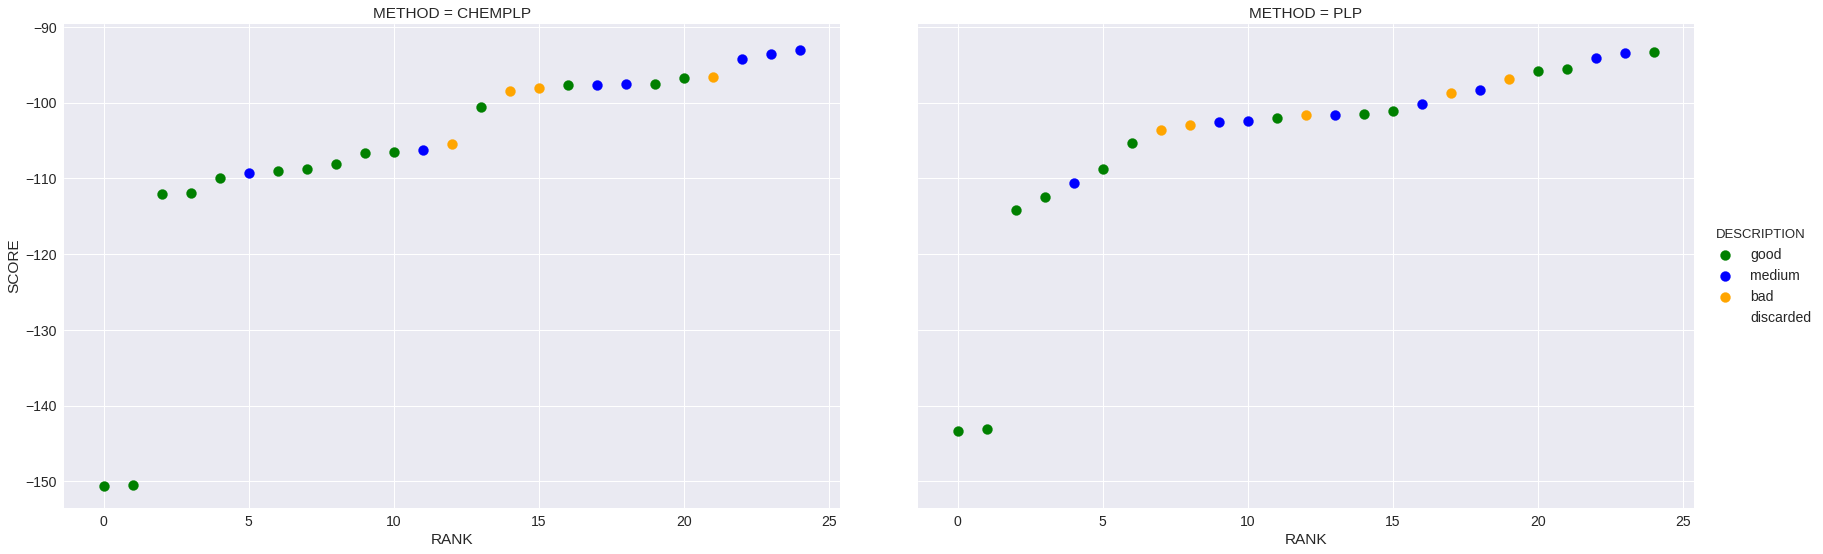

In [162]:
# Scatter plot : score by rank
g = sns.FacetGrid(data=all_subset ,hue='DESCRIPTION', hue_order=state_list, 
                  col='METHOD',
                  aspect=1.5, size=8, palette=state_color_list)

g.map(plt.scatter, 'RANK', 'SCORE', s=100)
g.add_legend()
plt.subplots_adjust(hspace=0.15,wspace=0.1)
            
plt.savefig('{}/scatter_rank_by_score_color_rmsd.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

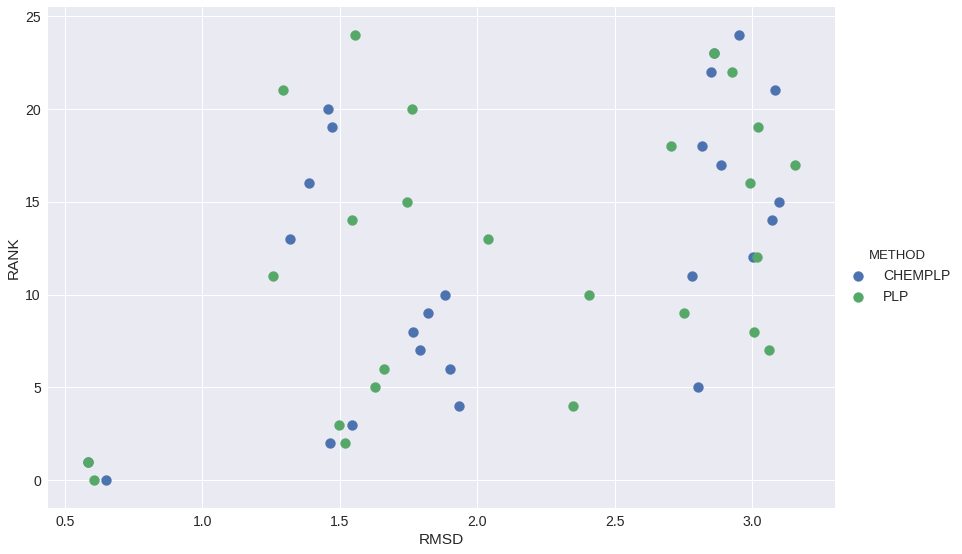

In [164]:
# Score by RMSD

g = sns.FacetGrid(data=all_subset ,hue='METHOD', 
                  aspect=1.5, size=8)

g.map(plt.scatter, 'RMSD', 'RANK', s=100)
_=g.add_legend()

plt.savefig('{}/scatter_score_by_rmsd.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')

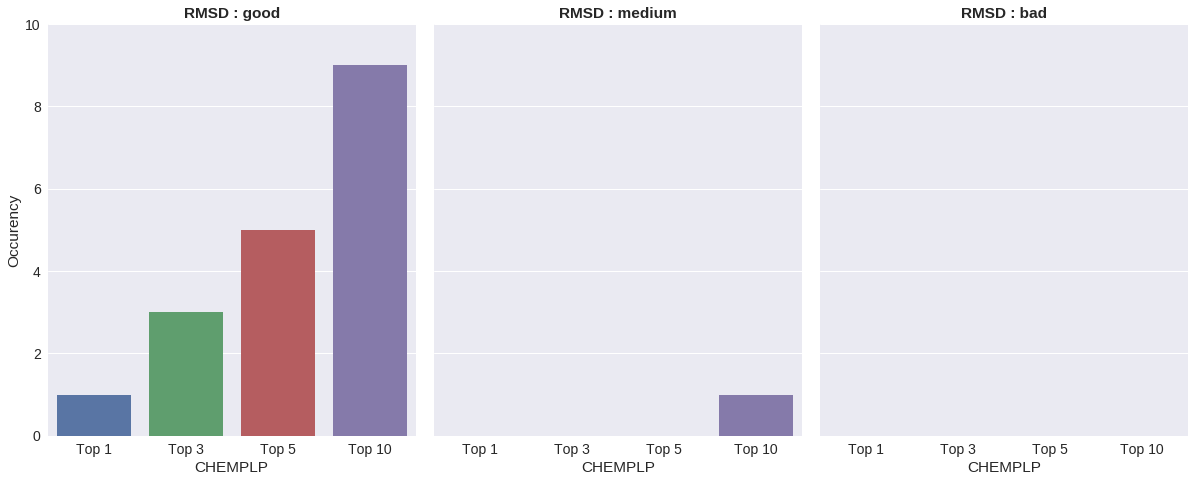

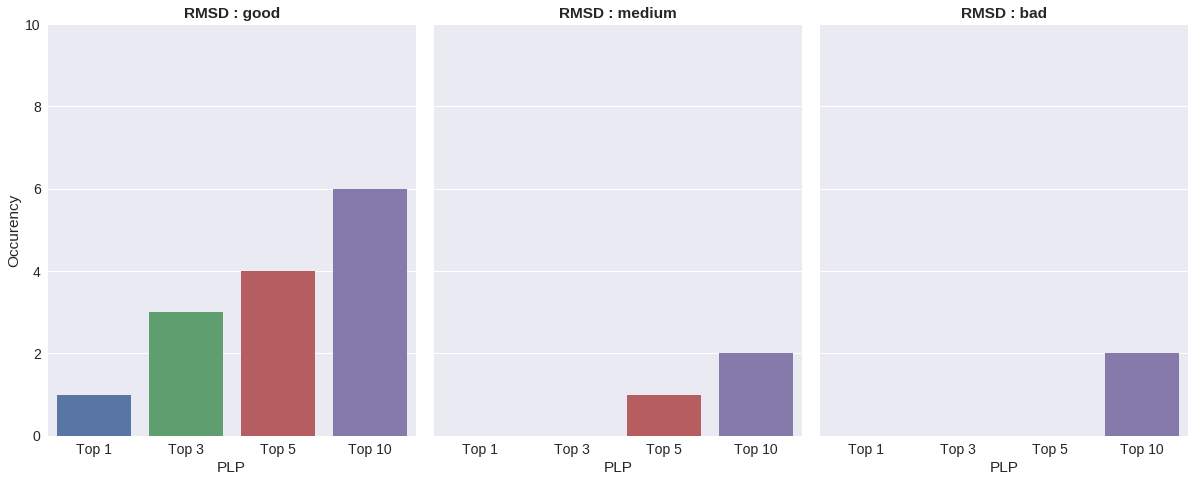

In [169]:
# Barplot occurency of poses with RMSD within range, for different top X range selection

for method in occurency['Method'].unique():
    g = sns.factorplot(kind='bar', data=occurency.loc[occurency['Method'] == method], 
                   x='Selection Range', y='Occurency',
                   col='Description', col_order=['good','medium', 'bad'], col_wrap=3,
                   aspect=0.8, size=7)
    g.set_axis_labels(method)
    ax = plt.gca()
    # Set y axis limit for the plot, so they share y axis
    ax.set_ylim([0,10])
    _=g.set_titles('RMSD : {col_name}',fontweight='bold')

plt.savefig('{}/barplot_range_selection.png'.format(save_folder), format='png', dpi=200,bbox_inches='tight')